In [1]:
import iris
import iris.coord_categorisation
import calendar
import numpy as np
import xarray as xr
import calendar
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from copy import copy
plt.rcParams['mathtext.default'] = 'regular'

#### Process data

In [2]:
# Read data
path_to_geos =  Path.cwd().parent.parent / 'geos-chem'
path_to_ukca = Path.cwd().parent / 'data'
geos = xr.open_dataset(path_to_geos / 'ocean_rono2_2013.nc')
ukca = iris.load_cube(str(path_to_ukca / 'xojng' / 'xojng_o3.nc'))
# Path to figures
path_to_figs = Path.cwd().parent.parent.parent / 'results' / 'rono2_emis'
publish = True
if publish:
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    mpl.rcParams['axes.titlesize'] = 12
    mpl.rcParams['axes.labelsize'] = 12
    plt.rcParams['font.size'] = 12

In [3]:
# Delete unnecessary UKCA coordinates leaving only time, latitude and longitude (just for convenience)
ukca.remove_coord('model_level_number')
ukca.remove_coord('forecast_reference_time')
ukca.remove_coord('forecast_period')
ukca.remove_coord('level_height')
ukca.remove_coord('sigma')

In [ ]:
geos

In [ ]:
ukca

So, GEOS-Chem's resolution is 2$\times$2.5 degrees (lat$\times$lon) (at the poles latitude step is 1.5 degrees). UKCA's v7.3 resolution is 2.5$\times$3.75 degrees (lat$\times$lon).

In [ ]:
geos.MeNO3_emission.lon.values

In [ ]:
ukca.coord('longitude').points

In [1]:
def roll_cube_w2e(cube_in, inplace=False):
    """Takes a cube which longitudes span -180...180 and rolls them by 180 degrees west to east to 0...360.
    Inspired by https://gist.github.com/dennissergeev/0e362a8a8a8f12b87221c1519b9903cf"""
    if inplace:
        cube = cube_in
    else:
        cube = cube_in.copy()
    lon = cube.coord('longitude')
    if (lon.points < 0.).any():
        add = 180
        cube.data = np.roll(cube.data, len(lon.points) // 2, axis=-1)
        if lon.has_bounds():
            bounds = lon.bounds + add
        else:
            bounds = None
        cube.replace_coord(lon.copy(points=lon.points + add, bounds=bounds))
    if not inplace:
        return cube

In [5]:
# Convert GEOS-Chem xarray dataset to iris cube
geos_meono2_emis = geos.MeNO3_emission.to_iris()
geos_etono2_emis = geos.EtNO3_emission.to_iris()
# Rename coordinates as iris expects
geos_meono2_emis.coord('Time, instantaneous or at start of averaging period').rename('time')
geos_meono2_emis.coord('Latitude').rename('latitude')
geos_meono2_emis.coord('Longitude').rename('longitude')
geos_etono2_emis.coord('Time, instantaneous or at start of averaging period').rename('time')
geos_etono2_emis.coord('Latitude').rename('latitude')
geos_etono2_emis.coord('Longitude').rename('longitude')
# Roll GEOS-Chem data west to east and regrid it onto UKCA grid
ukca_grid = [('longitude', ukca.coord('longitude').points), ('latitude', ukca.coord('latitude').points)]
_ukca_meono2_emis = roll_cube_w2e(geos_meono2_emis).interpolate(ukca_grid, iris.analysis.Linear())
_ukca_etono2_emis = roll_cube_w2e(geos_etono2_emis).interpolate(ukca_grid, iris.analysis.Linear())
# Variables to convert molecules cm-2 s-1 to kg m-2 s-1
avogadro_number = iris.coords.AuxCoord(6.022*1e23, units='molec/mol', long_name='avogadro_number')
molar_mass_meono2 = iris.coords.AuxCoord(77.0394, units='g/mol', long_name='molar_mass_of_methyl_nitrate')
molar_mass_etono2 = iris.coords.AuxCoord(91.0660, units='g/mol', long_name='molar_mass_of_ethyl_nitrate')
# Convert to kg m-2 s-1
ukca_meono2_emis = _ukca_meono2_emis / avogadro_number * molar_mass_meono2 
ukca_etono2_emis = _ukca_etono2_emis / avogadro_number * molar_mass_etono2 
ukca_meono2_emis.convert_units('kg/m2/s')
ukca_etono2_emis.convert_units('kg/m2/s')
ukca_meono2_emis.rename('methyl nitrate oceanic emission')
ukca_etono2_emis.rename('ethyl nitrate oceanic emission')
ukca_meono2_emis

Methyl Nitrate Oceanic Emission (kg/m2/s),time,latitude,longitude
Shape,12,73,96
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x


In [ ]:
# Quick look at the 'rolled' and regridded data
plt.pcolormesh(ukca_meono2_emis.coord('longitude').points, ukca_meono2_emis.coord('latitude').points, ukca_meono2_emis.data[0, ...]);

Looks correct.

#### Check land masks

In [6]:
# Read UM orography data
ukca_orog = iris.load_cube(str(path_to_ukca / 'um_orography_xnvtj.nc'), 'OROGRAPHY (/STRAT LOWER BC)')

/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'surface' invalid units 'level'
  warnings.warn(msg)


In [7]:
# Mask UKCA heights that are equal to zero, i.e. ocean/water = True, land/depressions like the Dead Sea = False
ukca_orog_masked = np.ma.masked_where(ukca_orog[0,0,...].data == 0., ukca_orog[0,0,...].data)
ukca_ocean_mask = ukca_orog_masked.mask # ocean is True
# Mask GEOS-Chem oceanic emissions that are equal to zero (in GEOS-Chem oceanic emissions are zero over land AND in the tropics)
geos_rono2_masked = np.ma.masked_where(ukca_meono2_emis[0,...].data == 0., ukca_meono2_emis[0,...].data)
geos_zero_emis = geos_rono2_masked.mask # zero emission is True
# Find non-zero oceanic emissions over land (i.e. impossible values) that result from the difference in grid resolution
correction_mask = np.broadcast_to((~ukca_ocean_mask) & (~geos_zero_emis), (12, 73, 96))
# Apply correction mask to the data and replace masked values with zero
ukca_meono2_emis_corrected = np.ma.masked_where(correction_mask, ukca_meono2_emis.data).filled(fill_value=0.)
ukca_etono2_emis_corrected = np.ma.masked_where(correction_mask, ukca_etono2_emis.data).filled(fill_value=0.)

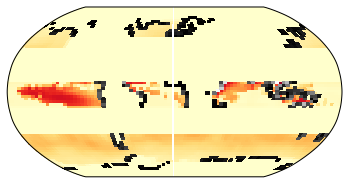

In [8]:
# Visualize land(+tropics) correction mask
lons = ukca.coord('longitude').points
lats = ukca.coord('latitude').points
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
# Unmasked data
ax.pcolormesh(lons, lats, ukca_meono2_emis[0,...].data, transform=ccrs.PlateCarree(), cmap='YlOrRd')
# Black-greyish colors highlight areas where land mask correction is applied
cmap_grid_diff = copy(plt.cm.gray) # changes from black to white
cmap_grid_diff.set_bad(alpha=0)
ax.pcolormesh(lons, lats, np.ma.masked_where(~correction_mask, ukca_meono2_emis.data)[0,...], transform=ccrs.PlateCarree(), cmap=cmap_grid_diff);

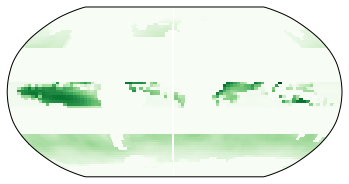

In [9]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
# Unmasked data
ax.pcolormesh(lons, lats, ukca_meono2_emis[0,...].data, transform=ccrs.PlateCarree(), cmap='YlOrRd')
# Black-greyish colors highlight areas where land mask correction is applied
cmap_grid_diff = copy(plt.cm.gray) # changes from black to white
cmap_grid_diff.set_bad(alpha=0)
ax.pcolormesh(lons, lats, np.ma.masked_where(~correction_mask, ukca_meono2_emis.data)[0,...], transform=ccrs.PlateCarree(), cmap=cmap_grid_diff)
# Masked data with fill value equal to zero where mask is applied
cmap_corrected = copy(plt.cm.Greens)
cmap_corrected.set_bad(alpha=0)
ax.pcolormesh(lons, lats, ukca_meono2_emis_corrected[0,...], transform=ccrs.PlateCarree(), cmap=cmap_corrected);

In [10]:
# Replace unmasked data in a cube with masked data
ukca_meono2_emis.data = ukca_meono2_emis_corrected
ukca_etono2_emis.data = ukca_etono2_emis_corrected

#### Derive n and iPrONO2 oceanic emissions

Dahl et al (2007): 'At the Equatorial stations (0–2.5°N, Figure 7, row B), methyl and ethyl nitrate concentrations were positively correlated at all depths with an [Me]/[Et] ratio of 6.0±0.2. [...] Isopropyl and ethyl nitrate concentrations were also positively correlated at all depths with an [iPr]/[Et] ratio of0.2±0.0. [...] N-propyl nitrate was positively correlated with ethyl nitrate with an [nPr]/[Et] ratio of 0.1±0.0'.

Disscussed with Jenny Fisher via email.

In [11]:
# Derive n and iPrONO2 oceanic emissions from EtONO2 oceanic emissions
ukca_nprono2_emis = ukca_etono2_emis*0.1
ukca_iprono2_emis = ukca_etono2_emis*0.2

#### Check global burdens

Fisher et al (2018): global burden due to oceanic emission for year 2013: MeONO2 is 157 Gg N a-1, EtONO2 is 27 Gg N a-1.

In [12]:
# Variables to convert to kg of N
avogadro_number_cb = iris.cube.Cube(6.022*1e23, units='molec/mol', long_name='avogadro_number')
molar_mass_meono2_cb = iris.cube.Cube(77.0394, units='g/mol', long_name='molar_mass_of_methyl_nitrate')
molar_mass_etono2_cb = iris.cube.Cube(91.0660, units='g/mol', long_name='molar_mass_of_ethyl_nitrate')
molar_mass_prono2_cb = iris.cube.Cube(105.0926, units='g/mol', long_name='molar_mass_of_propyl_nitrate')
molar_mass_n_cb = iris.cube.Cube(14.0067, units='g/mol', long_name='molar_mass_of_atomic_nitrogen')

Start with GEOS-Chem:

In [13]:
# Guess coordinate bounds
for coord in ['longitude', 'latitude']:
    if not geos_meono2_emis.coord(coord).has_bounds():
        geos_meono2_emis.coord(coord).guess_bounds()
    if not geos_etono2_emis.coord(coord).has_bounds():
        geos_etono2_emis.coord(coord).guess_bounds()
# Calculate emission per year by weighting monthly values by month's length and adding values up
n_days_per_month = np.asarray([calendar.monthrange(2013, i)[1] for i in range(1, 13)]) # number of days in each month in year 2013
geos_month_weights = iris.util.broadcast_to_shape(n_days_per_month, geos_meono2_emis.shape, (0,)) # weight of each month's length
geos_meono2_emis_per_year = (geos_meono2_emis * 
                             iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                            iris.analysis.SUM,
                                                                                                            weights=geos_month_weights)
geos_etono2_emis_per_year = (geos_etono2_emis * 
                             iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                            iris.analysis.SUM,
                                                                                                            weights=geos_month_weights)
# Add up all grid cells accounting for their varying area sizes
geos_norm_area_weights = iris.analysis.cartography.area_weights(geos_meono2_emis_per_year, normalize=True)
geos_meono2_emis_per_year_area_sum = geos_meono2_emis_per_year.collapsed(['longitude', 'latitude'], 
                                                                         iris.analysis.SUM,
                                                                         weights=geos_norm_area_weights)
geos_etono2_emis_per_year_area_sum = geos_etono2_emis_per_year.collapsed(['longitude', 'latitude'], 
                                                                         iris.analysis.SUM,
                                                                         weights=geos_norm_area_weights)

/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [14]:
# Calculate Earth's area
area_weights = iris.analysis.cartography.area_weights(geos_meono2_emis_per_year, normalize=False)
earth_area = iris.cube.Cube(area_weights.sum(), units='m2')

/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [15]:
# Calculate GEOS-Chem global burden
geos_meono2_emis_burden = geos_meono2_emis_per_year_area_sum * earth_area / avogadro_number_cb * molar_mass_n_cb
geos_etono2_emis_burden = geos_etono2_emis_per_year_area_sum * earth_area / avogadro_number_cb * molar_mass_n_cb
geos_meono2_emis_burden.convert_units('Gg')
geos_etono2_emis_burden.convert_units('Gg')
print('GEOS-Chem MeONO2 global emissions: ', geos_meono2_emis_burden.data, 'Gg N yr-1')
print('GEOS-Chem EtONO2 global emissions: ', geos_etono2_emis_burden.data, 'Gg N yr-1')

GEOS-Chem MeONO2 global emissions:  157.12963628790993 Gg N yr-1
GEOS-Chem EtONO2 global emissions:  26.948046324634973 Gg N yr-1


Same for UKCA:

In [16]:
# Guess coordinate bounds
for coord in ['longitude', 'latitude']:
    if not ukca_meono2_emis.coord(coord).has_bounds():
        ukca_meono2_emis.coord(coord).guess_bounds()
    if not ukca_etono2_emis.coord(coord).has_bounds():
        ukca_etono2_emis.coord(coord).guess_bounds()
    if not ukca_nprono2_emis.coord(coord).has_bounds():
            ukca_nprono2_emis.coord(coord).guess_bounds()
    if not ukca_iprono2_emis.coord(coord).has_bounds():
        ukca_iprono2_emis.coord(coord).guess_bounds()
# Calculate emission per year by weighting monthly values by month's length and adding values up
ukca_month_weights = iris.util.broadcast_to_shape(n_days_per_month, ukca_meono2_emis.shape, (0,))
ukca_meono2_emis_per_year = (ukca_meono2_emis * 
                             iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                            iris.analysis.SUM,
                                                                                                            weights=ukca_month_weights)
ukca_etono2_emis_per_year = (ukca_etono2_emis * 
                             iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                            iris.analysis.SUM,
                                                                                                            weights=ukca_month_weights)
ukca_nprono2_emis_per_year = (ukca_nprono2_emis * 
                              iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                             iris.analysis.SUM,
                                                                                                             weights=ukca_month_weights)
ukca_iprono2_emis_per_year = (ukca_iprono2_emis * 
                              iris.coords.AuxCoord(86400, units='s', long_name='seconds_per_day')).collapsed(['time'],
                                                                                                             iris.analysis.SUM,
                                                                                                             weights=ukca_month_weights)
# Add up all grid cells accounting for their varying area sizes
ukca_norm_area_weights = iris.analysis.cartography.area_weights(ukca_meono2_emis_per_year, normalize=True)
ukca_meono2_emis_per_year_area_sum = ukca_meono2_emis_per_year.collapsed(['longitude', 'latitude'],
                                                                         iris.analysis.SUM, 
                                                                         weights=ukca_norm_area_weights)
ukca_etono2_emis_per_year_area_sum = ukca_etono2_emis_per_year.collapsed(['longitude', 'latitude'],
                                                                         iris.analysis.SUM, 
                                                                         weights=ukca_norm_area_weights)
ukca_nprono2_emis_per_year_area_sum = ukca_nprono2_emis_per_year.collapsed(['longitude', 'latitude'],
                                                                           iris.analysis.SUM, 
                                                                           weights=ukca_norm_area_weights)
ukca_iprono2_emis_per_year_area_sum = ukca_iprono2_emis_per_year.collapsed(['longitude', 'latitude'],
                                                                           iris.analysis.SUM, 
                                                                           weights=ukca_norm_area_weights)
# Calculate UKCA global burden
ukca_meono2_emis_burden = ukca_meono2_emis_per_year_area_sum * earth_area * avogadro_number_cb / molar_mass_meono2_cb * molar_mass_n_cb
ukca_etono2_emis_burden = ukca_etono2_emis_per_year_area_sum * earth_area * avogadro_number_cb / molar_mass_etono2_cb * molar_mass_n_cb
ukca_nprono2_emis_burden = ukca_nprono2_emis_per_year_area_sum * earth_area * avogadro_number_cb / molar_mass_prono2_cb * molar_mass_n_cb
ukca_iprono2_emis_burden = ukca_iprono2_emis_per_year_area_sum * earth_area * avogadro_number_cb / molar_mass_prono2_cb * molar_mass_n_cb
ukca_meono2_emis_burden.convert_units('Gg')
ukca_etono2_emis_burden.convert_units('Gg')
ukca_nprono2_emis_burden.convert_units('Gg')
ukca_iprono2_emis_burden.convert_units('Gg')
print('UKCA MeONO2 global oceanic emissions: ', ukca_meono2_emis_burden.data, 'Gg N yr-1')
print('UKCA EtONO2 global oceanic emissions: ', ukca_etono2_emis_burden.data, 'Gg N yr-1')
print('UKCA nPrONO2 global oceanic emissions: ', ukca_nprono2_emis_burden.data, 'Gg N yr-1')
print('UKCA iPrONO2 global oceanic emissions: ', ukca_iprono2_emis_burden.data, 'Gg N yr-1')

UKCA MeONO2 global oceanic emissions:  141.3895470786689 Gg N yr-1
UKCA EtONO2 global oceanic emissions:  24.24968859185833 Gg N yr-1
UKCA nPrONO2 global oceanic emissions:  2.1013107881108386 Gg N yr-1
UKCA iPrONO2 global oceanic emissions:  4.202621576221677 Gg N yr-1


/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHE

So, we lost ~15 Gg (9.8%) of MeONO2 and ~2.6 Gg (9.8%) of EtONO2 after regridding and applying the land mask... Most of the difference comes from applying the UKCA land mask in the Indian Ocean.


From Jenny Fisher's email: '... if you applied those to the total global ocean source of EtNO3 from my Table 1, you would get ~2.7 Gg N/yr nPrNO3 and ~5.4 Gg N/yr iPrNO3'.

In [2]:
(141.3895470786689+24.24968859185833+2.1013107881108386+4.202621576221677)*1e-3 # Gg N yr-1 to Tg N yr-1

0.17194316803485976

#### Create perpetual year 2013 emissions

In [ ]:
# Repeat emissions data 10 times along time axis
perpetual_meono2_emis_arr = np.moveaxis(np.tile(np.moveaxis(ukca_meono2_emis.data, 0, -1), 10), -1, 0)
perpetual_etono2_emis_arr = np.moveaxis(np.tile(np.moveaxis(ukca_etono2_emis.data, 0, -1), 10), -1, 0)
perpetual_nprono2_emis_arr = np.moveaxis(np.tile(np.moveaxis(ukca_nprono2_emis.data, 0, -1), 10), -1, 0)
perpetual_iprono2_emis_arr = np.moveaxis(np.tile(np.moveaxis(ukca_iprono2_emis.data, 0, -1), 10), -1, 0)
# Create a new time dimention or copy ukca.coord('time') if shapes are the same
if perpetual_meono2_emis_arr.shape == ukca.coord('time').shape:
    time = ukca.coord('time')
else:
    start_date = ukca.coord('time').points[0]
    hours_since_start_date = np.arange(start_date, start_date+10*12*30*24, 720) # montly intervals in hours using 360 day calendar
    time = iris.coords.DimCoord(hours_since_start_date, standard_name='time', var_name='time', units=ukca.coord('time').units)

In [ ]:
# Create iris cubes
perpetual_meono2_emis_cb = iris.cube.Cube(perpetual_meono2_emis_arr, long_name='methyl_nitrate_oceanic_emission', units='kg/m2/s',
                                          dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_etono2_emis_cb = iris.cube.Cube(perpetual_etono2_emis_arr, long_name='ethyl_nitrate_oceanic_emission', units='kg/m2/s',
                                          dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_nprono2_emis_cb = iris.cube.Cube(perpetual_nprono2_emis_arr, long_name='npropyl_nitrate_oceanic_emission', units='kg/m2/s',
                                          dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_iprono2_emis_cb = iris.cube.Cube(perpetual_iprono2_emis_arr, long_name='ipropyl_nitrate_oceanic_emission', units='kg/m2/s',
                                          dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])

#### Plot figures

In [35]:
lats = ukca.coord('latitude').points

In [36]:
meono2 = ukca_meono2_emis.copy()
etono2 = ukca_etono2_emis.copy()
nprono2 = ukca_nprono2_emis.copy()
iprono2 = ukca_iprono2_emis.copy()
# Add a season coordinate
iris.coord_categorisation.add_season(meono2, 'time', name='season')
iris.coord_categorisation.add_season(etono2, 'time', name='season')
iris.coord_categorisation.add_season(nprono2, 'time', name='season')
iris.coord_categorisation.add_season(iprono2, 'time', name='season')

In [37]:
# Annual sum
meono2_ann, lons = cartopy.util.add_cyclic_point(meono2.collapsed('time', iris.analysis.SUM).data, coord=meono2.coord('longitude').points)
etono2_ann = cartopy.util.add_cyclic_point(etono2.collapsed('time', iris.analysis.SUM).data)
nprono2_ann = cartopy.util.add_cyclic_point(nprono2.collapsed('time', iris.analysis.SUM).data)
iprono2_ann = cartopy.util.add_cyclic_point(iprono2.collapsed('time', iris.analysis.SUM).data)
# Mask zero emissions
mskd_meono2_ann = np.ma.masked_where(meono2_ann.data<=0.00000000e+00, meono2_ann.data)
mskd_etono2_ann = np.ma.masked_where(etono2_ann.data<=0.00000000e+00, etono2_ann.data)
mskd_nprono2_ann = np.ma.masked_where(nprono2_ann.data<=0.00000000e+00, nprono2_ann.data)
mskd_iprono2_ann = np.ma.masked_where(iprono2_ann.data<=0.00000000e+00, iprono2_ann.data)
# Find max annual emission
ann_max = max(meono2_ann.max(), etono2_ann.max(), nprono2_ann.max(), iprono2_ann.max())

/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/miniconda3/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


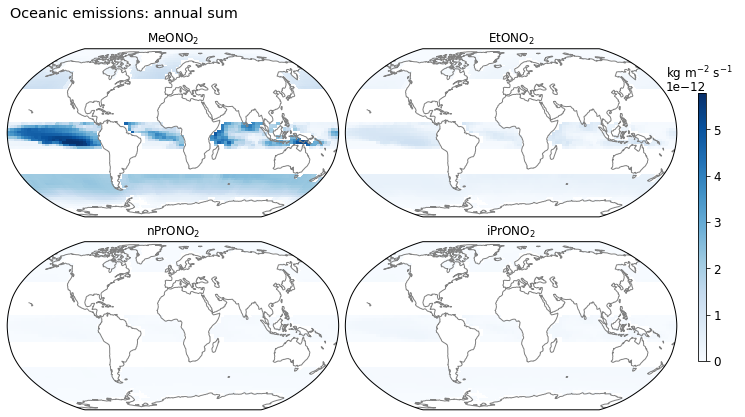

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
# Hide zero emissions
cmap_hide = copy(plt.cm.Blues)
cmap_hide.set_bad('w', 0)
p00 = ax[0,0].pcolormesh(lons, lats, mskd_meono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
ax[0,1].pcolormesh(lons, lats, mskd_etono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
ax[1,0].pcolormesh(lons, lats, mskd_nprono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
ax[1,1].pcolormesh(lons, lats, mskd_iprono2_ann, transform=ccrs.PlateCarree(), vmin=0, vmax=ann_max, cmap=cmap_hide);
# common
ax[0,0].set_title('$MeONO_2$')
ax[0,1].set_title('$EtONO_2$')
ax[1,0].set_title('$nPrONO_2$')
ax[1,1].set_title('$iPrONO_2$')
for iax in ax.flatten(): iax.coastlines(color='grey') 
cax = fig.add_axes([0.925, 0.35, 0.009, 0.31])
cb00 = fig.colorbar(p00, cax=cax, orientation='vertical')
cb00.ax.set_title('kg $m^{-2}$ $s^{-1}$  ', pad=15);
fig.suptitle('Oceanic emissions: annual sum', x=0.26, y=0.76)#, weight='bold')
fig.subplots_adjust(hspace=-0.58, wspace=0.02)
fig.savefig(path_to_figs / f'rono2_oc_emis_ann.png', bbox_inches='tight', dpi=300)

In [49]:
# Seasonal sum
meono2_ssn = cartopy.util.add_cyclic_point(meono2.aggregated_by(['season'], iris.analysis.SUM).data)
etono2_ssn = cartopy.util.add_cyclic_point(etono2.aggregated_by(['season'], iris.analysis.SUM).data)
nprono2_ssn = cartopy.util.add_cyclic_point(nprono2.aggregated_by(['season'], iris.analysis.SUM).data)
iprono2_ssn = cartopy.util.add_cyclic_point(iprono2.aggregated_by(['season'], iris.analysis.SUM).data)
# Mask zero emissions
mskd_meono2_ssn = np.ma.masked_where(meono2_ssn.data<=0.00000000e+00, meono2_ssn.data)
mskd_etono2_ssn = np.ma.masked_where(etono2_ssn.data<=0.00000000e+00, etono2_ssn.data)
mskd_nprono2_ssn = np.ma.masked_where(nprono2_ssn.data<=0.00000000e+00, nprono2_ssn.data)
mskd_iprono2_ssn = np.ma.masked_where(iprono2_ssn.data<=0.00000000e+00, iprono2_ssn.data)
# Find max ssnual emission
ssn_max = max(meono2_ssn.max(), etono2_ssn.max(), nprono2_ssn.max(), iprono2_ssn.max())

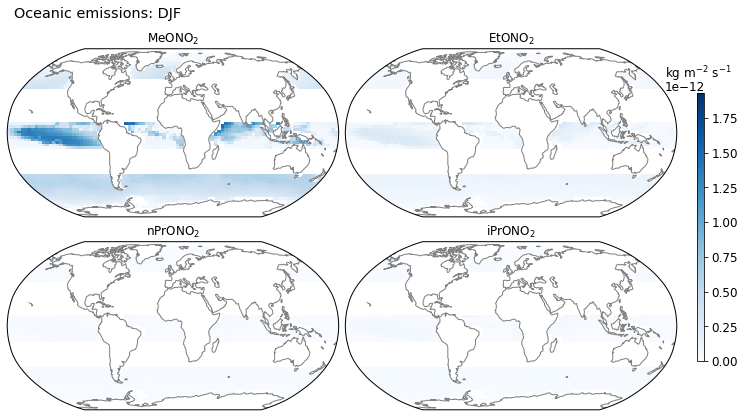

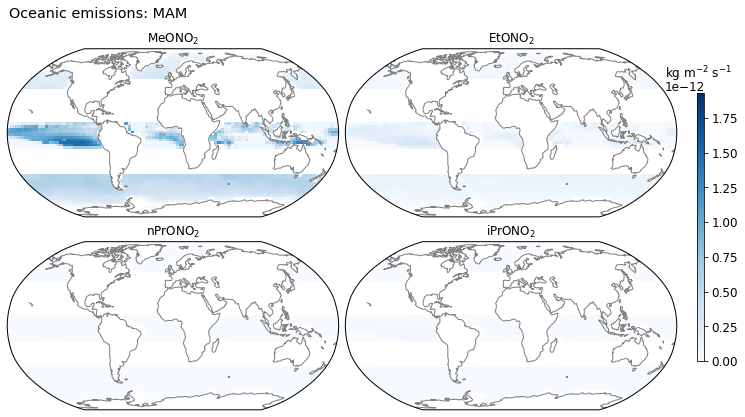

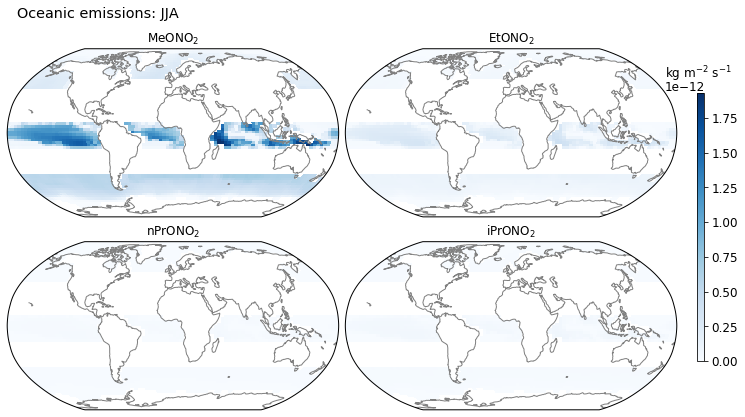

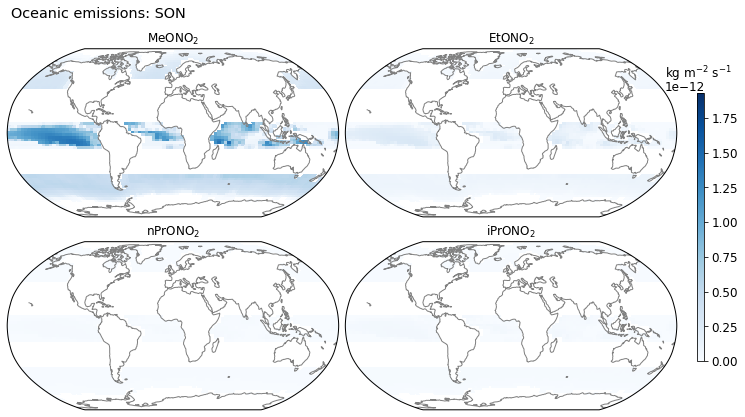

In [50]:
for issn, ssn in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
    # Hide zero emissions
    cmap_hide = copy(plt.cm.Blues)
    cmap_hide.set_bad('w', 0)
    p00 = ax[0,0].pcolormesh(lons, lats, mskd_meono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    ax[0,1].pcolormesh(lons, lats, mskd_etono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    ax[1,0].pcolormesh(lons, lats, mskd_nprono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    ax[1,1].pcolormesh(lons, lats, mskd_iprono2_ssn[issn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=ssn_max, cmap=cmap_hide);
    # common
    ax[0,0].set_title('$MeONO_2$')
    ax[0,1].set_title('$EtONO_2$')
    ax[1,0].set_title('$nPrONO_2$')
    ax[1,1].set_title('$iPrONO_2$')
    for iax in ax.flatten(): iax.coastlines(color='grey') 
    cax = fig.add_axes([0.923, 0.35, 0.009, 0.31])
    cb00 = fig.colorbar(p00, cax=cax, orientation='vertical')
    cb00.ax.set_title('kg $m^{-2}$ $s^{-1}$  ', pad=15);
    fig.suptitle(f'Oceanic emissions: {ssn}', x=0.23, y=0.76)#, weight='bold')
    fig.subplots_adjust(hspace=-0.58, wspace=0.02)
    fig.savefig(path_to_figs / f'rono2_oc_emis_ssn_{issn+1}.png', bbox_inches='tight', dpi=300)

In [51]:
# Monthly
meono2_mon = cartopy.util.add_cyclic_point(meono2.data)
etono2_mon = cartopy.util.add_cyclic_point(etono2.data)
nprono2_mon = cartopy.util.add_cyclic_point(nprono2.data)
iprono2_mon = cartopy.util.add_cyclic_point(iprono2.data)
# Mask zero emissions
mskd_meono2_mon = np.ma.masked_where(meono2_mon.data<=0.00000000e+00, meono2_mon.data)
mskd_etono2_mon = np.ma.masked_where(etono2_mon.data<=0.00000000e+00, etono2_mon.data)
mskd_nprono2_mon = np.ma.masked_where(nprono2_mon.data<=0.00000000e+00, nprono2_mon.data)
mskd_iprono2_mon = np.ma.masked_where(iprono2_mon.data<=0.00000000e+00, iprono2_mon.data)
# Find max monthly emission
mon_max = max(meono2_mon.max(), etono2_mon.max(), nprono2_mon.max(), iprono2_mon.max())

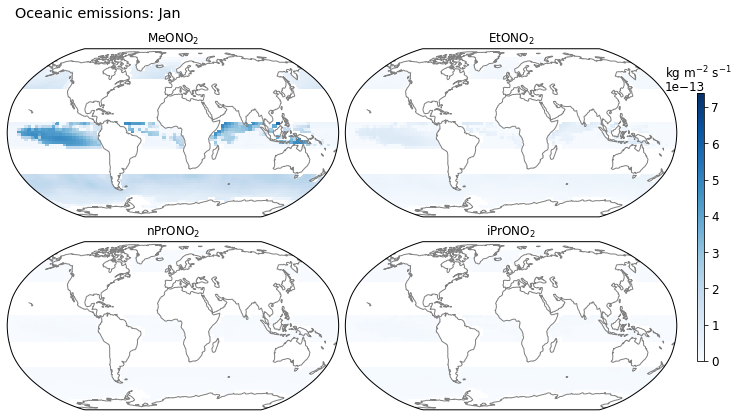

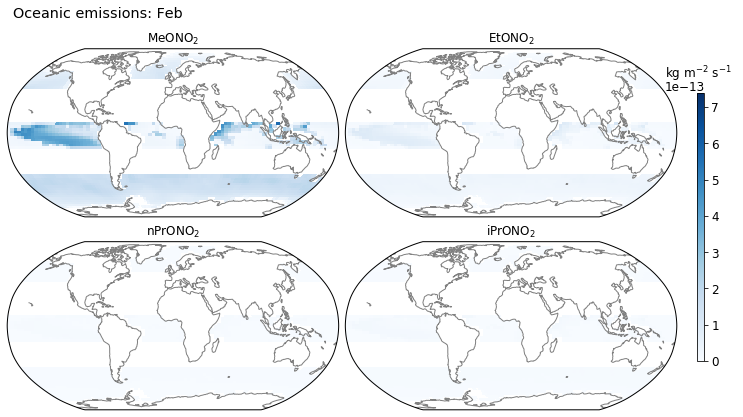

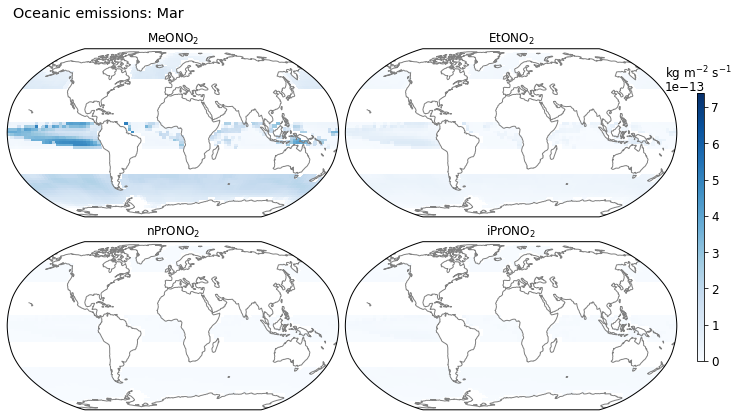

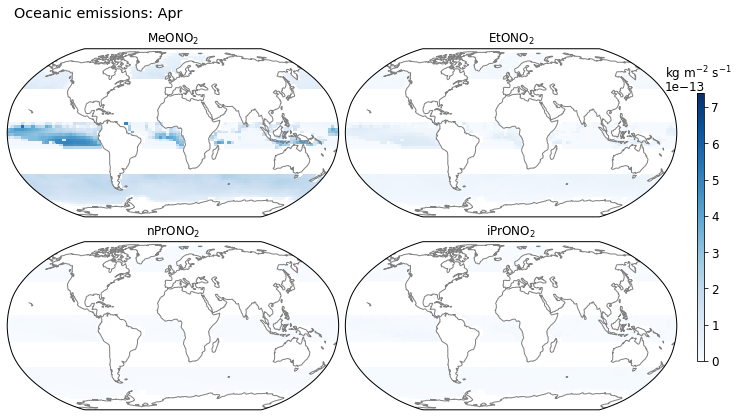

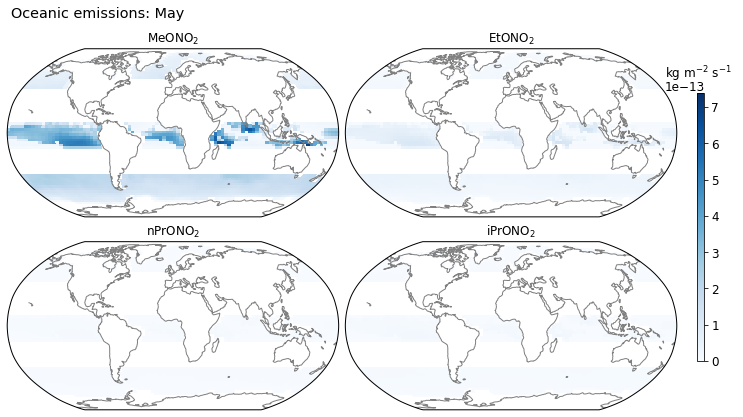

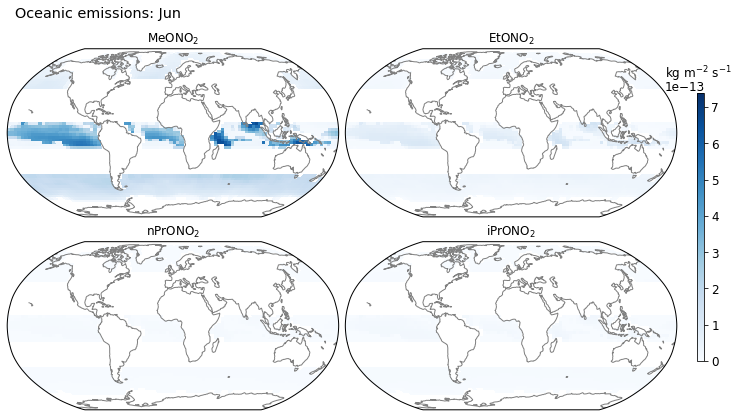

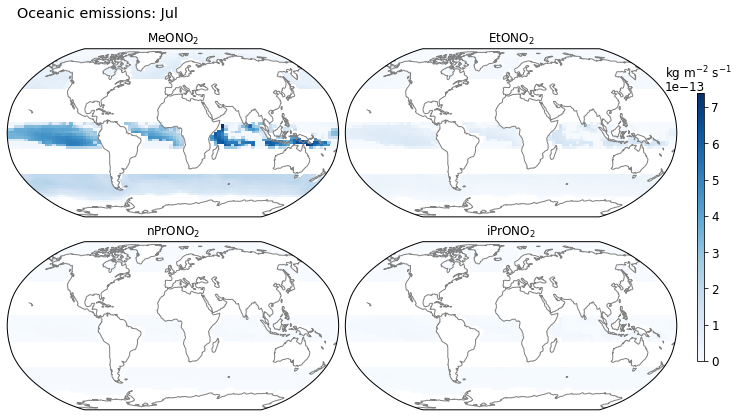

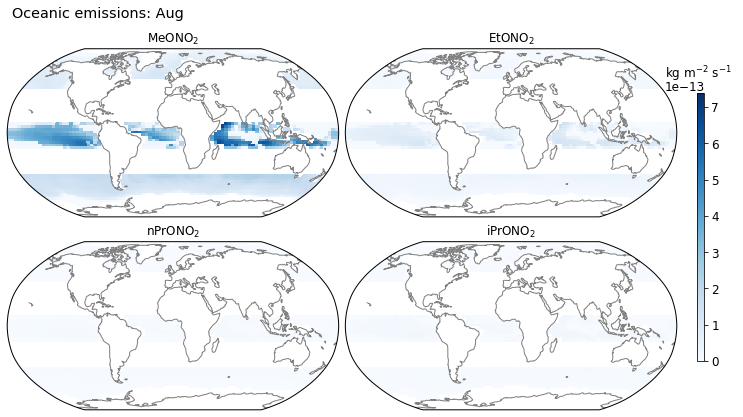

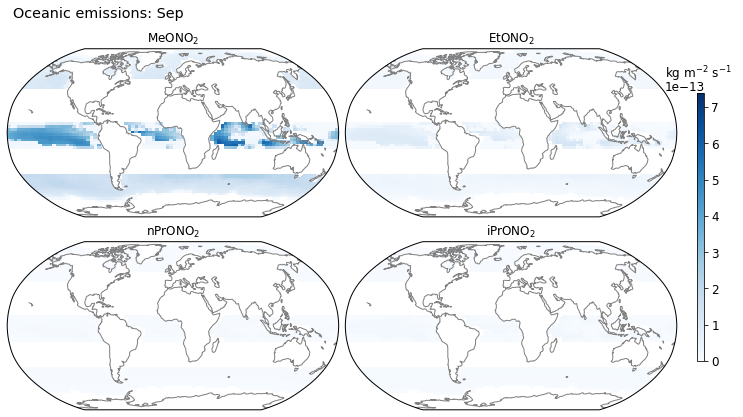

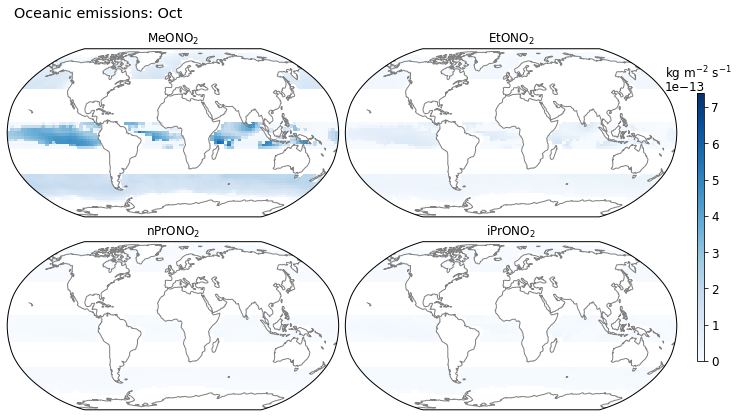

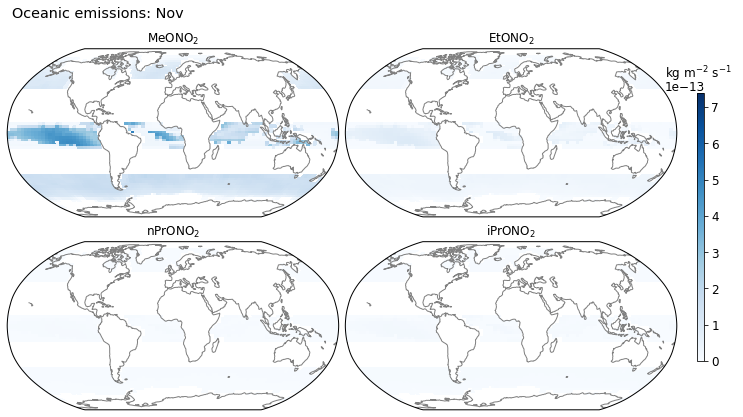

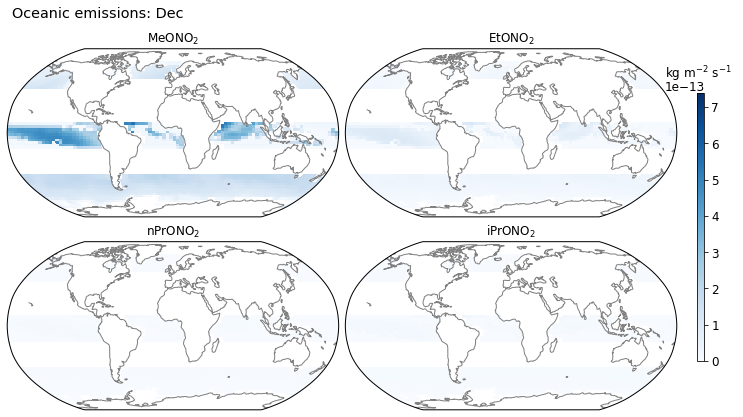

In [52]:
for imn, nmn in enumerate([calendar.month_abbr[i] for i in range(13)][1:]):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
    # Hide zero emissions
    cmap_hide = copy(plt.cm.Blues)
    cmap_hide.set_bad('w', 0)
    p00 = ax[0,0].pcolormesh(lons, lats, mskd_meono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    ax[0,1].pcolormesh(lons, lats, mskd_etono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    ax[1,0].pcolormesh(lons, lats, mskd_nprono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    ax[1,1].pcolormesh(lons, lats, mskd_iprono2_mon[imn,...], transform=ccrs.PlateCarree(), vmin=0, vmax=mon_max, cmap=cmap_hide);
    # common
    ax[0,0].set_title(f'$MeONO_2$')
    ax[0,1].set_title(f'$EtONO_2$')
    ax[1,0].set_title(f'$nPrONO_2$')
    ax[1,1].set_title(f'$iPrONO_2$')
    for iax in ax.flatten(): iax.coastlines(color='grey') 
    cax = fig.add_axes([0.923, 0.35, 0.009, 0.31])
    cb00 = fig.colorbar(p00, cax=cax, orientation='vertical')
    cb00.ax.set_title('kg $m^{-2}$ $s^{-1}$  ', pad=15);
    fig.suptitle(f'Oceanic emissions: {nmn}', x=0.23, y=0.76)#, weight='bold')
    fig.subplots_adjust(hspace=-0.58, wspace=0.02)
    fig.savefig(path_to_figs / f'rono2_oc_emis_mon_{imn+1}.png', bbox_inches='tight', dpi=300)

In [53]:
# # Add cyclic longitude point
# ukca_meono2_emis_cyc, ukca_lons_cyc = cartopy.util.add_cyclic_point(ukca_meono2_emis.data, coord=ukca_meono2_emis.coord('longitude').points)
# ukca_etono2_emis_cyc = cartopy.util.add_cyclic_point(ukca_etono2_emis.data)
# # Find min and max
# vmin_meono2 = np.min(ukca_meono2_emis_cyc[0,...].data)
# vmax_meono2 = np.max(ukca_meono2_emis_cyc[0,...].data)
# vmin_etono2 = np.min(ukca_etono2_emis_cyc[0,...].data)
# vmax_etono2 = np.max(ukca_etono2_emis_cyc[0,...].data)

In [54]:
# def plot_emis(lons, lats, cb, vmin, vmax, specie_latex, specie_str, source, mn_name, mn_num):
#     fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
#     p0 = ax.pcolormesh(lons, lats, cb, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap='Blues')
#     ax.set_title(f'{specie_latex} oceanic emissions\n{mn_name}')
#     ax.coastlines()
#     fig.colorbar(p0, ax=ax, shrink=0.4, label='kg $m^{-2}$ $s^{-1}$')
#     # # Set black color where data is 0.0
#     # cmap_hide = copy(plt.cm.Blues)
#     # cmap_hide.set_bad('w', 0.5)
#     # ax.pcolormesh(ukca_lons_cyc, lats, np.ma.masked_where(ukca_meono2_emis_cyc.data==0.0, ukca_meono2_emis_cyc.data)[0,...],
#     #               transform=ccrs.PlateCarree(), cmap=cmap_hide);
#     fig.savefig(path_to_figs / f'{source}_rono2_{specie_str}_oceanic_emissions_{mn_num}.png', bbox_inches='tight')

In [55]:
# def plot_emis_publish(lons, lats, cb, vmin, vmax, specie_latex, specie_str, source, mn_name, mn_num):
#     plt.rcParams['mathtext.default'] = 'regular'
#     mpl.rcParams['xtick.labelsize'] = 20
#     mpl.rcParams['ytick.labelsize'] = 20
#     mpl.rcParams['axes.titlesize'] = 40
#     plt.rcParams['font.size'] = 30
#     fig, ax = plt.subplots(figsize=(20,20), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
#     p0 = ax.pcolormesh(lons, lats, cb, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap='Blues')
#     ax.set_title(f'{mn_name}') # f'{specie_latex} oceanic emissions\n{mn_name}'
#     ax.coastlines()
#     fig.colorbar(p0, ax=ax, shrink=0.4, label='kg $m^{-2}$ $s^{-1}$')
#     fig.savefig(path_to_figs / f'{source}_rono2_{specie_str}_oceanic_emissions_{mn_num}_publ.png', bbox_inches='tight')

In [56]:
# for i, mn_name in enumerate(calendar.month_abbr[1:13]):
#     plot_emis_publish(ukca_lons_cyc, lats, ukca_meono2_emis_cyc[i,...].data, vmin_meono2, vmax_meono2, '$MeONO_2$', 'c1', 'ukca', mn_name, f'{i+1}')
# for i, mn_name in enumerate(calendar.month_abbr[1:13]):
#     plot_emis(ukca_lons_cyc, lats, ukca_meono2_emis_cyc[i,...].data, vmin_meono2, vmax_meono2, '$MeONO_2$', 'c1', 'ukca', mn_name, f'{i+1}')
# for i, mn_name in enumerate(calendar.month_abbr[1:13]):
#     plot_emis(ukca_lons_cyc, lats, ukca_etono2_emis_cyc[i,...].data, vmin_etono2, vmax_etono2, '$EtONO_2$', 'c2', 'ukca', mn_name, f'{i+1}')
# plot_emis(ukca_lons_cyc, lats, ukca_etono2_emis_cyc[12-1,...].data, vmin_etono2, vmax_etono2, '$EtONO_2$', 'c2', 'ukca', 'Dec', '12')

In [57]:
# Save iris cubes
iris.save(perpetual_meono2_emis_cb, str(path_to_ukca / 'rono2_emis' /'perpetual_meono2_oceanic_emissions.nc'))
iris.save(perpetual_etono2_emis_cb, str(path_to_ukca / 'rono2_emis' /'perpetual_etono2_oceanic_emissions.nc'))
iris.save(perpetual_nprono2_emis_cb, str(path_to_ukca / 'rono2_emis' /'perpetual_nprono2_oceanic_emissions.nc'))
iris.save(perpetual_iprono2_emis_cb, str(path_to_ukca / 'rono2_emis' /'perpetual_iprono2_oceanic_emissions.nc'))

NameError: name 'perpetual_meono2_emis_cb' is not defined